## House Prices - Advanced Regression Techniques
Predict sales prices and practice feature engineering, RFs, and gradient boosting

https://www.kaggle.com/competitions/house-prices-advanced-regression-techniques

In [1]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from d2l import torch as d2l

In [2]:
train_data = pd.read_csv("./data/house-prices-advanced-regression-techniques/train.csv")
test_data = pd.read_csv("./data/house-prices-advanced-regression-techniques/test.csv")

print(train_data.shape,test_data.shape)

(1460, 81) (1459, 80)


In [3]:
train_data.iloc[0:4,[0,1,2,3,-4,-3,-2,-1]]

,Id,MSSubClass,MSZoning,LotFrontage,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,2008,WD,Normal,208500
1,2,20,RL,80.0,2007,WD,Normal,181500
2,3,60,RL,68.0,2008,WD,Normal,223500
3,4,70,RL,60.0,2006,WD,Abnorml,140000


In [4]:
test_data.iloc[0:4,[0,1,2,3,-4,-3,-2,-1]]

,Id,MSSubClass,MSZoning,LotFrontage,MoSold,YrSold,SaleType,SaleCondition
0,1461,20,RH,80.0,6,2010,WD,Normal
1,1462,20,RL,81.0,6,2010,WD,Normal
2,1463,60,RL,74.0,3,2010,WD,Normal
3,1464,60,RL,78.0,6,2010,WD,Normal


In [5]:
all_features = pd.concat((train_data.iloc[:, 1:-1], test_data.iloc[:, 1:]))
# 正则化 (均值为0 方差为1)
numeric_features = all_features.dtypes[all_features.dtypes != 'object'].index
all_features[numeric_features] = all_features[numeric_features].apply(
    lambda x: (x - x.mean()) / (x.std()))
all_features[numeric_features] = all_features[numeric_features].fillna(0)
all_features.iloc[[1,2,3],[-3,-2,-1]]

,YrSold,SaleType,SaleCondition
1,-0.602858,WD,Normal
2,0.157619,WD,Normal
3,-1.363335,WD,Abnorml


In [6]:
all_features = pd.get_dummies(all_features,dummy_na=True)
all_features.shape

(2919, 331)

In [7]:
train_num = train_data.shape[0]
train_features = torch.tensor(all_features[:train_num].values,dtype=torch.float32)
test_features = torch.tensor(all_features[train_num:].values,dtype=torch.float32)
train_labels = torch.tensor(train_data.iloc[:,-1].values.reshape((-1,1)),dtype=torch.float32)
train_labels

tensor([[208500.],
        [181500.],
        [223500.],
        ...,
        [266500.],
        [142125.],
        [147500.]])

In [8]:
loss = torch.nn.MSELoss()

def log_rmse(net,features,labels):
    cliped_pred = torch.clamp(net(features),1,float('inf'))
    log_loss = torch.sqrt(loss(torch.log(cliped_pred),torch.log(labels)))
    return log_loss

In [9]:
def train(net, train_features, train_labels, test_features, test_labels,
          num_epochs, learning_rate, weight_decay, batch_size):
    train_ls, test_ls = [], []
    train_iter = d2l.load_array((train_features, train_labels), batch_size)
    optimizer = torch.optim.Adam(net.parameters(),
                                 lr = learning_rate,
                                 weight_decay = weight_decay)
    for epoch in range(num_epochs):
        for X, y in train_iter:
            optimizer.zero_grad()
            l = loss(net(X), y)
            l.backward()
            optimizer.step()
        train_ls.append(log_rmse(net, train_features, train_labels).detach())
        if test_labels is not None:
            test_ls.append(log_rmse(net, test_features, test_labels).detach())
    return train_ls, test_ls

def get_k_fold_data(k, i, X, y):
    assert k > 1
    fold_size = X.shape[0] // k
    X_train, y_train = None, None
    for j in range(k):
        idx = slice(j * fold_size, (j + 1) * fold_size)
        X_part, y_part = X[idx, :], y[idx]
        if j == i:
            X_valid, y_valid = X_part, y_part
        elif X_train is None:
            X_train, y_train = X_part, y_part
        else:
            X_train = torch.cat([X_train, X_part], 0)
            y_train = torch.cat([y_train, y_part], 0)
    return X_train, y_train, X_valid, y_valid

def k_fold(k, X_train, y_train, num_epochs, learning_rate, weight_decay,
           batch_size):
    train_l_sum, valid_l_sum = 0, 0
    for i in range(k):
        data = get_k_fold_data(k, i, X_train, y_train)
        net = get_net()
        train_ls, valid_ls = train(net, *data, num_epochs, learning_rate,
                                   weight_decay, batch_size)
        train_l_sum += train_ls[-1]
        valid_l_sum += valid_ls[-1]
        if i == 0:
            d2l.plot(list(range(1, num_epochs + 1)), [train_ls, valid_ls],
                     xlabel='epoch', ylabel='rmse', xlim=[1, num_epochs],
                     legend=['train', 'valid'], yscale='log')
        print(f'折{i + 1}，训练log rmse{float(train_ls[-1]):f}, '
              f'验证log rmse{float(valid_ls[-1]):f}')
    return train_l_sum / k, valid_l_sum / k


### Linear Regression

折1，训练log rmse0.169758, 验证log rmse0.156537
折2，训练log rmse0.162371, 验证log rmse0.191815
折3，训练log rmse0.163923, 验证log rmse0.168563
折4，训练log rmse0.167659, 验证log rmse0.154543
折5，训练log rmse0.163499, 验证log rmse0.183020
5-折验证: 平均训练log rmse: 0.165442, 平均验证log rmse: 0.170896


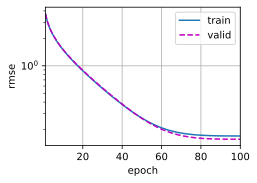

In [10]:
def get_net():
    net = nn.Sequential(nn.Linear(train_features.shape[1],1))
    #net = nn.Sequential(nn.Linear(train_features.shape[1],256),nn.Linear(256,1))
    return net

k, num_epochs, lr, weight_decay, batch_size = 5, 100, 5, 0, 64
train_l, valid_l = k_fold(k, train_features, train_labels, num_epochs, lr,
                          weight_decay, batch_size)
print(f'{k}-折验证: 平均训练log rmse: {float(train_l):f}, '
      f'平均验证log rmse: {float(valid_l):f}')


过拟合程度很低，效果良好。

## Multilayer Perceptron

折1，训练log rmse0.135577, 验证log rmse0.155352
折2，训练log rmse0.123091, 验证log rmse0.176229
折3，训练log rmse0.141807, 验证log rmse0.195642
折4，训练log rmse0.126948, 验证log rmse0.168006
折5，训练log rmse0.114000, 验证log rmse0.167879
5-折验证: 平均训练log_rmse: 0.128284, 平均验证log_rmse: 0.172622


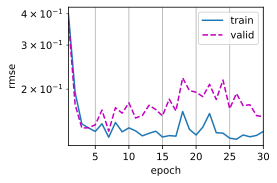

In [11]:
def get_net():
    #net = nn.Sequential(nn.Linear(train_features.shape[1],1))
    net = nn.Sequential(nn.Linear(train_features.shape[1],256),nn.Linear(256,1))
    for m in net:
        if type(m) == nn.Linear:
            nn.init.xavier_normal_(m.weight)
    return net

k, num_epochs, lr, weight_decay, batch_size = 5, 30, 0.4, 10, 64
train_l, valid_l = k_fold(k, train_features, train_labels, num_epochs, lr,
                          weight_decay, batch_size)
print(f'{k}-折验证: 平均训练log_rmse: {float(train_l):f}, 平均验证log_rmse: {float(valid_l):f}')


Xavier初始化的多层感知机，在有权重衰减的情况下也能取得较好的效果，但出现了较为明显的过拟合，证明多层感知机对这个数据集过于复杂